# Problem Set 2 - Decision Trees, Ensemble Methods
***
**Name**: Peter Rock
***

This assignment is due on Canvas by **11:59PM on Wednesday February 22**.

Submit only this Jupyter notebook to Canvas with the name format `PS2_<yourname>.ipynb`. Do not compress it using tar, rar, zip, etc.
Your solutions to analysis questions should be done in Markdown directly below the associated question.

Remember that you are encouraged to discuss the problems with your classmates and instructors, 
but **you must write all code and solutions on your own**, and list any people or sources consulted.
The only exception to this rule is that you may copy code directly from your own solution to homework 1.
***

## Overview 

Your task for this homework is to build a decision tree classifier from scratch. Of course, we provide some initial classes
that you'll be editing. Since last two problems will use the scikit-learn's DecisionTreeClassifier, your solution
does not have to be efficient as long as it passes the sanity checks in a reasonable time (typically less than ~1min).

We will run a small comparison between our implementation and Scikit's in Problem 2 to make sure we didn't miss anything.

The third part will introduce k-fold cross validation to find out how deep is the best decision tree classifier. The last problem
requires a _weak learner_ (implemented as `base` model), so we'll use a decision tree that yields lower performance. But with _Ensemble Methods_,
we will be able to improve the performance by aggregating predictions from multiple weak learners.
For the ensemble methods, we'll explore bagging, Random Forest, and boosting (AdaBoost).

Any Machine Learning interview will almost certainly have a question or two about decision trees and how they're trained.
So understanding the code and trying to implement everything on your own will be the best way to prepare for such interviews.

Also remember, if your code is correct then the sanity checks should pass without any major issue.
But if the sanity checks pass that does not necessarily imply your code is 100% correct.

Happy coding!

In [1]:
import numpy as np
import matplotlib.pylab as plt
import tests
import data
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

### Problem 1 - Decision Trees [30 points]
***
The goal of this problem is to implement the core elements of the Decision Tree classifier.
We do not expect a highly efficient implementation of the functions since the ensemble methods will use the implementation from scikit-learn.


|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | Yes|
| 25 | 52,000 | Yes | No  | Yes|

In [2]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

Each leaf node (terminal node) in a decision tree has a label value assigned to it. The same label will be assigned
to all samples that reach the leaf node.
- 1.1 [2 pts] What is the best accuracy for a baseline classifier that predicts one label for all rows on the dataset above?
which label should it predict?

% Write-up for 1.1 <br>
#BEGIN <br>
For the baseline classifier given above, the best label to predict would be "Yes" for the college degree since 7/12 of 
the entries in the table have that label. This gives us an accuracy of ~58.3%

#END<br>

- 1.2 [3 pts] Complete `compute_label` to return the label that should be assigned to the leaf node based on training labels in `y`.

If more than one label are possible, choose the one with the lowest value (e.g, if both `0` and `1` are possible,
choose `0`)

In [3]:
class Node:
    """Base class for LeafNode and ParentNode"""
    left_child = None
    right_child = None
    def feature_importance(self, importance_dict):
        return importance_dict

class LeafNode(Node):
    def __init__(self, y):
        """
        :param y: 1-d array containing labels, of shape (num_points,)
        """
        self.label = self.compute_label(y)

    @staticmethod
    def compute_label(y):
        """
        return the label that yields best performance if predicted of all instances in y
        :param y:  1-d array containing labels
        :return: single label, integer
        """
        node_label = None
        #Workspace 1.2
        #TODO: Return the label that should be assigned to the leaf node
        #In case of multiple possible labels, choose the one with the lowest value
        #Make no assumptions about the number of class labels
        #BEGIN
        label_count = {}
        for item in y:
            label_count[item] = label_count.get(item, 0) + 1;
            
        max_count = max(label_count.values())
        possible_labels = []
        
        for key, value in label_count.items():
            if value == max_count:
                possible_labels.append(key)
        #END
        return min(possible_labels)


    def predict(self, x):
        """
        return the label for one obervation x
        :param x: one sample, of shape (num_features)
        :return: label, integer
        """
        return self.label

In [4]:
# Test cell, uncomment to run the tests
tests.test_leaf(LeafNode)

Question 1.2: [PASS]


The tree also contains _parent nodes_. They can either be parents of: leaf nodes, parent nodes, or a combination of the two.
Each parent node has a left and a right child. A parent node is used when we can reduce the impurity of the labels by splitting
the training instances based on a certain threshold.

First, we'll need to choose an impurity measure. For classification,
there are two mainstream measures: _gini index_ and _entropy_. We'll be using the former for our implementation.

\begin{align}
\text{Gini}(y) = 1 - \sum_{c}  (p_c)^2 \text{  and  Entropy}(y) = -\sum_{c}  p_c . \log p_c ,
\end{align}

where $p_c$ is the probability of occurrence (ratio)  of class $c$ among the labels in $y$. *Make sure that the log function being used for entropy is np.log() as it calculates $log_e()$*  

- 1.3 [3 pts] Complete the function `gini` that returns the gini index of labels in `y`.

_Hint: Make sure you handle multi-class labels
(not just binary)._

In [5]:
def gini(y):
    """
    :param y: 1-d array contains labels, of shape (num_points,)
    :return: float, entropy measure of the labels
    """
    # Workspace 1.3
    #TODO: Compute the gini index of the labels
    #BEGIN
    label_count = {}
    for item in y:
        label_count[item] = label_count.get(item, 0) + 1
    
    gini_index = 1 - sum((float(item)/len(y))**2 for item in label_count.values())
    #END
    return gini_index


In [6]:
# Test cell, uncomment to run the tests
tests.test_gini(gini)

Question 1.3: [PASS]


Now that we're at a parent node, we decide to partition our label instances in $S$ to two parts indexed by $P_1$ and $P_2$,
and we want to compute how much this split reduces the impurity.

Using the impurity measure $\mathcal{M}$, this impurity reduction is computed as follows:
\begin{align}
\text{Reduction}(S, {P_1, P_2}) = \mathcal{M}(S) - \big[
    \frac{|P_1|}{|S|} .\mathcal{M}(S[P_1]) + \frac{|P_2|}{|S|}.\mathcal{M}(S[P_2])
    \big],
\end{align}

where $|A|$ denotes the size of the set $A$.

The main questions will be based on the entropy measure, in which case the `Reduction` is also called _information gain_
(reducing the entropy implies that the partitioning decision variable and the labels have a higher mutual information).

-  1.4 [3 pts] Complete the `impurity_reduction` function to return the impurity reduction of the split using the provided measure.

In [7]:
def impurity_reduction(y, left_indices, right_indices, impurity_measure=gini):
    """
    :param y: all labels
    :param left_indices: the indices of the elements of y that belong to the left child
    :param right_indices: the indices of the elements of y that belong to the right child
    :param impurity_measure: function that takes 1d-array of labels and returns the impurity measure, defaults to gini
    :return: impurity reduction of the split
    """
    impurity_reduce = 0
    # Workspace 1.4
    #BEGIN
    p1 = y[left_indices]
    p2 = y[right_indices]
    impurity_reduce = impurity_measure(list(y)) - ( float(len(p1)/len(y))*impurity_measure(p1) + 
                                              float(len(p2)/len(y))*impurity_measure(p2) )

    #END
    return impurity_reduce

In [8]:
# Test cell, uncomment to run the tests
tests.test_information_gain(impurity_reduction, gini)

Question 1.4: [PASS]


We'll use `best_partition` to look up for the feature and threshold that yields the partition with the best impurity reduction.

For each feature:
 - Compute all possible thresholds (use `split_values`)
 - For each threshold:
    - Split to `(left_indices, right_indices)` based on the threshold
    - Compute the impurity reduction of the split

The function then returns the feature and the threshold that yield the best impurity reduction (and the reduction value)

 - 1.5 [5 pts] Complete `best_partition`.
 
 _Hint: `split_values` is provided as a helper function. It takes the feature column and returns
the set of thresholds_

In [9]:
def split_values(feature_values):
    """
    Helper function to return the split values. if feature consists of the values f1 < f2 < f3 then
    this returns [(f2 + f1)/2, (f3 + f2)/2]
    :param feature_values: 1-d array of shape (num_points)
    :return: array of shape (max(m-1, 1),) where m is the number of unique values in feature_values
    """
    unique_values = np.unique(feature_values)
    if unique_values.shape[0] == 1:
        return unique_values
    return (unique_values[1:] + unique_values[:-1]) / 2


def best_partition(X, y, impurity_measure=gini):
    """
    :param X: features array, shape (num_samples, num_features)
    :param y: labels of instances in X, shape (num_samples)
    :param impurity_measure: function that takes 1d-array of labels and returns the impurity measure
    :return: Return the best value and its corresponding threshold by splitting based on the different features.
    """

    best_feature, best_threshold, best_reduction = 0, 0, -np.inf

    #Workspace 1.5
    #TODO: Complete the function as detailed in the question and return description
    #BEGIN
    for i in range(len(X[0])):
        feature_values = X[:,i]
        possible_splits = split_values(feature_values)
        
        
        for threshold in possible_splits:
            left_indices = [j for j in range(len(feature_values)) if feature_values[j] < threshold]
            right_indices = [j for j in range(len(feature_values)) if feature_values[j] >= threshold]
            
            reduction = impurity_reduction(y, left_indices, right_indices, gini)
            
            if reduction > best_reduction:
                best_reduction = reduction
                best_threshold = threshold
                best_feature = i
            
    #END
    return best_feature, best_threshold, best_reduction

In [10]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
tests.test_best_partition(best_partition, gini)

Question 1.5: [PASS]


We provide the implementation of the parent node below. Note that the `left_child` will take instance for which
`feature_id` value is < `feature_threshold`. We should construct our decision tree as such.

In [11]:
class ParentNode:

    def __init__(self, feature_id, feature_threshold, left_child: Node, right_child: Node, weighted_impurity=0):
        """
        Initialize a parent node.
        :param feature_id: the feature index on which the splitting will be done
        :param feature_threshold: the feature threshold. Left child takes item with features[features_id] < threshold
        :param left_child: left child node
        :param right_child: right child node
        :param weighted_impurity: weighted impurity reduction, optional (used for the bonus question)
        """
        self.feature_id = feature_id
        self.threshold = feature_threshold
        self.left_child = left_child
        self.right_child = right_child
        self.weighted_impurity = weighted_impurity

    def feature_importance(self, importance_dict):
        """
        :param importance_dict: dictionary, keys are features indices adn value are feature importances
        :return: updated feature importrances dictionary
        """
        #Workspace 2.5.a (bonus)
        #BEGIN
        left_weight = len(self.left_child) / (len(self.left_child) + len(self.right_child))
        right_weight = len(self.right_child) / (len(self.left_child) + len(self.right_child))
        importance_dict[self.feature_id] += (self.weighted_impurity * (1 - (left_weight ** 2) - (right_weight ** 2)))
        importance_dict = self.left_child.feature_importance(importance_dict)
        importance_dict = self.right_child.feature_importance(importance_dict)
        #END
        return importance_dict

    def predict(self, x):
        """
        Predict the label of row x. If we're a leaf node, return the value of the leaf. Otherwise, call predict
        of the left/right child (depending on x[feature_index).
        This will be called by DecisionTree.predict
        :param x: 1-d array of shape (num_features)
        :return: integer, the label for x
        """
        if x[self.feature_id] < self.threshold:
            label = self.left_child.predict(x)
        else:
            label = self.right_child.predict(x)
        return label

Now we tackle the core of a decision tree. The tree is built in a recursive way. The recursion in `DecisionTree.build` works as follows:
- Parameters: `min_samples_split`, `impurity_measure`
- Inputs: `features`, `labels`, `depth`
- Base case of the recursion, return a leaf node if either:
    - `depth` is 0
    - `labels` contains less than `min_samples_split` elements
    - There is no impurity reduction (reduction<=0 for all splits)
- Recursion (there is a split with impurity reduction > 0):
    - create the left and right child nodes with `depth - 1`
    - return the parent node

The left child node will contain instances for which the feature with index `best_feature` is strictly lower than
`best_threshold` of the partition. The right child takes the remaining instances.

- 1.6 [6 pts] Complete `build` method of `DecisionTree`
- 1.7 [2 pts] Complete the `score` method that returns the accuracy on the given data

In [12]:
class DecisionTree:

    def __init__(self, max_depth=-1, min_samples_split=2, impurity_measure=gini):
        """
        Initialize the decision tree
        :param max_depth: maximum depth of the tree
        :param min_samples_split: minimum number of samples required for a split
        :param impurity_measure: impurity measure function to use for best_partition, default to entropy
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.impurity_measure = impurity_measure
        self.root = None
        self.num_features = None
        
        return

    # def build(self, X, y, depth)->Node:\
    def build(self, X, y, depth):
        """
        Recursive method used to build the decision tree nodes
        :param X: data that are used to build the tree, of shape (num_samples, num_features)
        :param y: labels of the samples in features, of shape (num_samples)
        :param depth: depth of the tree to create
        :return: the root node of the tree
        """
        # Workspace 1.6
        #BEGIN
        # self.root = None
        # measure = self.impurity_measure
        # min_samples = self.min_samples_split
        # depth = min(depth, self.max_depth)
    
        
        if depth < 1 or len(y) < self.min_samples_split:
            return LeafNode(y)
        
        best_feature, best_threshold, best_reduction = best_partition(X,y,self.impurity_measure)
        
        if best_reduction == 0:
            return LeafNode(y)
        
        right_ind = np.where(X[:, best_feature] < best_threshold)
        left_ind = np.where(X[:, best_feature] >= best_threshold)
        
        
        right_data = np.delete(X, obj = right_ind, axis=0)
        right_y = np.delete(y, obj = right_ind, axis=0)
        left_data = np.delete(X, obj = left_ind, axis=0)
        left_y = np.delete(y, obj = left_ind, axis=0)
        
        left_node = self.build(left_data,left_y,depth-1)
        right_node = self.build(right_data,right_y,depth-1)
        
        
        def imp_red(y, left_indices, right_indices, impurity_measure=self.impurity_measure):
            impurity_reduce = 0
            p1 = y[left_indices]
            p2 = y[right_indices]
            impurity_reduce = impurity_measure(y) - ( float(len(p1)/len(y))*impurity_measure(p1) + 
                                                    float(len(p2)/len(y))*impurity_measure(p2) )
            return impurity_reduce
        
        impurity_red = (len(y))*imp_red(y= y, left_indices= left_ind, right_indices= right_ind)
        
        return ParentNode(feature_id= best_feature, feature_threshold= best_threshold, left_child= left_node, right_child= right_node, weighted_impurity= impurity_red)

        # END


    def fit(self, X, y):
        """
        :param X: Training samples
        :param y: training labels
        :return: trained classifier
        """
        self.num_features = X.shape[1]
        self.root = self.build(X, y, self.max_depth)
        return self

    def compute_importance(self, features_names=None):
        """
        Compute the normalized feature importances
        :param features_names: Name of features to use, defaults to integers
        :return: Dictionary with feature_name: feature_importance
        """
        if features_names is None:
            features_names = ["feat_%i" % i for i in range(self.num_features)]
        feats_importances = {i:0.0 for i in range(self.num_features)} # to include
        # Workspace 2.5.b (bonus)
        # ToDo: Call the root's feature and importance and scale values in feats_importance to sum to 1
        total_importances = 1
        #BEGIN
        def traverse_tree(node, feats_importances):
            if isinstance(node, LeafNode):
                return

            feats_importances[node.feature_id] += node.weighted_impurity
            traverse_tree(node.left_child, feats_importances)
            traverse_tree(node.right_child, feats_importances)
        
        
        traverse_tree(self.root, feats_importances)
        
        total_importance = sum(feats_importances.values())
        feats_importances = {key: value / total_importance for key, value in feats_importances.items()}
        #END
        return {features_names[k] :v for k,v in feats_importances.items() if v>0}

    def predict(self, X):
        """
        Loops through rows of X and predicts the labels one row at a time
        """
        y_hat = np.zeros((X.shape[0],), int)
        for i in range(X.shape[0]):
            y_hat[i] = self.root.predict(X[i])
        return y_hat

    def score(self, X, y):
        """
        Return the mean accuracy on the given test data and labels.
        :param X: Test samples, shape (num_points, num_features)
        :param y: true labels for X, shape (num_points,)
        :return: mean accuracy
        """
        accuracy = 0
        # Workspace 1.7
        #BEGIN
        y_hat = self.predict(X)
        accuracy = np.sum(y_hat == y)/len(y)
        #END
        return accuracy

In [13]:
# Test cell, uncomment to run the tests
# If you chose to not use split_values, then this test will likely fail
tests.test_tree_build(DecisionTree, gini)

Question 1.6: [PASS]


- 1.8 [2 pts] We want to evaluate our `DecisionTree(max_depth=3, min_samples_split=2`.
What's the accuracy we achieve on the training data using the tree? ( we train and evaluate using `(features, labels)`)

In [14]:
# Workspace 1.8
#BEGIN
tree = DecisionTree(max_depth=3, min_samples_split=2)
tree.fit(features, labels)
print(f"The accuracy on the training data set is {tree.score(features, labels)*100:0.2f}%")
#END

The accuracy on the training data set is 91.67%


- 1.9 [2 pts] Using `min_samples_split=2`, what is the minimum depth so that our `DecisionTree` fits perfectly our
training data `(labels, features)`.

In [15]:
# Workspace 1.9
# To show that the minimum required depth is n, you can provide the accuracy for depth = (n-1) and depth = n
#BEGIN

score = 0
it = 0

while score != 1 and it < 10:
    tree = DecisionTree(max_depth=it)
    tree.fit(features, labels)
    score = tree.score(features, labels)
    print(score)
    it += 1
        


#END

0.5833333333333334
0.75
0.9166666666666666
0.9166666666666666
0.9166666666666666
1.0


We provide an example below to display the structure of a decision tree. Look at print_tree() in tests.\_\_init\_\_.py to understand how this visualization is working.
- 1.10 (2pts) Edit it to show the tree for the required minimum depth found in 1.8

In [16]:
tree = DecisionTree(max_depth=3, min_samples_split=3).fit(features, labels)
tests.print_tree(tree, ["age", "salary", "resident", "siblings"])

                  ┌│label: 0
       ┌|salary  │┘
       │|36500.00│┐
       │          │       ┌│label: 1
       │          └|age  │┘
       │           |37.50│┐
       │                  └│label: 1
|age  │┘
|52.50│┐
       └│label: 0


### Problem 2: DecisionTree vs DecisionTreeClassifier [6 points]

We've just showed that our decision tree is better than the naive NaiveBayes! Let see how it compares to scikit's
DecisionTreeClassifier.

First, we'll need a fancier dataset. We are going to predict the level of usage of a bike sharing system in Washington, DC using the decision trees.

We start by loading preprocessed data that we'll use. Since the original Bike Sharing
 [dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)
 is for regression, we have to transform `BikeSharing.y_train` and `BikeSharing.y_test` to discrete values reflecting the level of usage.
We have included this dataset with the homework -- you can find it in the data directory.

|Bike Rentals| Label|
|:----------:|--:|
| $ P < $2000|0|
|2000$\leq P < $ 4000| 1 |
|4000$ \leq P < $ 6000| 2 |
|6000$ \leq P $ | 3 |

- 2.1 [3 pts] Start by transforming `y_train` and `y_test` of `bike_sharing` to discrete values using the provided ranges

In [17]:
bike_sharing = data.BikeSharing()
#Workspace 2.1
#TODO: Discretize y_train and y_test
#BEGIN
A1 = np.logical_and(bike_sharing.y_train >= 2000, bike_sharing.y_train < 4000).astype(int)
A2 = np.logical_and(bike_sharing.y_train >= 4000, bike_sharing.y_train < 6000).astype(int)*2
A3 = (bike_sharing.y_train >= 6000).astype(int)*3
bike_sharing.y_train = np.add(A1, A2, A3)

A1 = np.logical_and(bike_sharing.y_test >= 2000, bike_sharing.y_test < 4000).astype(int)
A2 = np.logical_and(bike_sharing.y_test >= 4000, bike_sharing.y_test < 6000).astype(int)*2
A3 = (bike_sharing.y_test >= 6000).astype(int)*3
bike_sharing.y_test = np.add(A1, A2, A3)

#END
print(np.unique(bike_sharing.y_train), bike_sharing.X_train.shape)
print(np.unique(bike_sharing.y_test), bike_sharing.X_test.shape)

[0 1 2] (584, 12)
[0 1 2] (147, 12)


- 2.2 [3 pts] Compare our `DecisionTree` and scikit's `DecisionTreeClassifier` on the bike sharing dataset by reporting the accuracies on the test data.

 [scikit's `DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
uses Gini Index by default and shuffles the features before each split. Refer to the documentation for more information about how to change the impurity measure if you are curious.

Use `max_depth = 5, min_samples_split=2, random_state=11` for the comparison.

In [18]:
# Workspace 2.2.a
#BEGIN
tree = DecisionTree(max_depth=5, min_samples_split=2)
tree.fit(bike_sharing.X_train, bike_sharing.y_train)
tree_score = tree.score(bike_sharing.X_test,bike_sharing.y_test)

sktree = DecisionTreeClassifier(max_depth= 5, min_samples_split= 2, random_state= 11)
sktree.fit(bike_sharing.X_train, bike_sharing.y_train)
sk_score = sktree.score(bike_sharing.X_test, bike_sharing.y_test)

print(tree_score)
print(sk_score)
#END

0.7074829931972789
0.7074829931972789


% Write-up for 2.2.b <br>
#BEGIN <br>
Hey look! They are the same! It's almost like we are implementing the same method.

#END<br>

### Bonus questions
We've implemented `DecisionTree` to handle different measures of impurity. We want now to compare our implementation
to the standard `DecisionTreeClassifier` using Gini index.
- **(Bonus)** 2.3  [2 pts] Complete `entropy` function
_hint: for the log function, use `np.log` and the convention `0 * log(0) = 0`._

In [19]:
def entropy(y):
    """
    :param y: 1-d array contains labels, of shape (num_points,)
    :return: float, gini index the labels
    """
    entropy_value = 0
    # Workspace 2.3
    #TODO: Compute the gini index of the labels in y
    #BEGIN
    label_counts = np.unique(y, return_counts=True)[1]
    label_probs = label_counts / len(y)
    for i in range(len(label_probs)):
        if label_probs[i] != 0:
            entropy_value -= label_probs[i]*np.log(label_probs[i])
            
    #END
    return entropy_value

- **(Bonus)** 2.4 [2 pts] Perform the same comparison as in 2.2 with entropy but without setting the random state.
How do you explain the result?

In [20]:
np.random.seed(2) # to fix the randomness in DecisionTreeClassifier
# Workspace 2.4.a
#BEGIN
tree = DecisionTree(max_depth=5, min_samples_split=2)
tree.fit(bike_sharing.X_train, bike_sharing.y_train)
tree_score = entropy(tree.predict(bike_sharing.X_test))

sktree = DecisionTreeClassifier(max_depth= 5, min_samples_split= 2, random_state= 11)
sktree.fit(bike_sharing.X_train, bike_sharing.y_train)
sk_score = entropy(sktree.predict(bike_sharing.X_test))

print(tree_score)
print(sk_score)
#END

1.0872810748980641
1.0872810748980641


% Write-up for 2.4.b <br>
#BEGIN <br>
Again, it looks like we are getting the same thing.

#END<br>

**(Bonus)**

Now we can be a bit more ambitious and compute the importance of each feature in our decision tree. The importance of feature $f$
is the sum of the weighted impurity reduction of parent nodes that are split based on the feature $f$.

The weighted impurity reduction of $node_i$ is the following:

\begin{align}
\frac{N_{\text{node}_i}}{N_\text{total}} \times \text{impurity reduction}({\text{node}_i}),
\end{align}

where $N$ is the total number of training samples, and $N_{\text{node}_i}$ is the number of training samples that at $node_i$.

Since we scale the feature importances in `DecisionTree` to sum to 1, we don't have to divide by $N_\text{total}$
and we can simply use:

\begin{align}
\text{weighted impurity}(\text{node}_i) = N_{\text{node}_i} \times \text{impurity reduction}({\text{node}_i}),
\end{align}

Practically, we use a dictionary `feats_importances` that maps feature indices to their importances.
- Start with `feats_importance[f]=0` for all `f`
- Start the recursion from the root node:
    - Current node is split based on feature `i`
    - add weighted impurity reduction to `feature_importance[i]`
    - ask right and left child to do the same
- Scale the values in `feats_importance` to sum to 1   
- return `feats_importance`

You can provide `weighted_impurity` directly when initializing the parent nodes in `DecisionTree.build`.

- **(Bonus)** 2.5 [4 pts] Complete `ParentNode`'s `feature_importance`, `DecisionTree`'s `compute_importance`, and 
compare our implementation to that of scikits on bike sharing data.

Use `random_state=0, splitter="best"` for scikit and `max_depth=3`, `min_samples_split=2`, gini index for both.
Note that scikit's DecisonTreeClassifier always uses Gini for the feature importance computation (even if `criterion` is set to Entropy).

In [21]:
# Workspace 2.5
# Compare feature importances of DecisionTree(gini) to DecisionTreeClassifier
# Exclude features with 0 importance from both
#BEGIN
tree = DecisionTree(max_depth=5, min_samples_split=2)
tree.fit(bike_sharing.X_train, bike_sharing.y_train)
tree_import = tree.compute_importance()
print(tree_import)

sktree = DecisionTreeClassifier(max_depth= 3, min_samples_split= 2, random_state= 0, splitter="best")
sktree.fit(bike_sharing.X_train, bike_sharing.y_train)
sk_import = {}
for i in range(len(sktree.feature_importances_)):
    if sktree.feature_importances_[i] > 0:
        sk_import["feat_%i"%i] = sktree.feature_importances_[i]
sk_import
#END

{'feat_0': 0.4335196321909901, 'feat_6': 0.007242151288705777, 'feat_7': 0.024450627160232018, 'feat_8': 0.1628433274287988, 'feat_9': 0.2972642691279419, 'feat_10': 0.07467999280333125}


{'feat_0': 0.48699189929686826,
 'feat_7': 0.033216667706865294,
 'feat_8': 0.17307448774626863,
 'feat_9': 0.30671694524999776}

### Problem 3 - Model Selection via Cross Validation [16 points]
***
In this problem, we will be working with scikit-learn `DecisionTreeClassifier`. We want to figure out the best `max_depth`
 for our dataset.

In the bike sharing dataset, we only have a training set and a test set. The question then is how do we perform the model
 selection seen in Problem Set 1?

One way to do so is via **the cross validation set approach** which basically means setting aside a portion of
our training data to use as a validation set. The goal is to use the validation set to find the best hyperparameters
for our model (`max_depth` in the case of decision trees).

- 3.1 [3 points] complete the `cross_validate` function to train the classifier on the training set and
return the accuracy on the validation set based on provided indices.

In [22]:
def cross_validate(classifier, X, y, train_indices, valid_indices):
    """
    Train classifier on training set and validate on the validation set
    :param classifier: the classifier to use
    :param X: all data of shape (num_samples, num_features)
    :param y: all labels of shape (num_samples)
    :param train_indices:  indices to be used for training the model
    :param valid_indices:  indices to be used for validating the model
    :return: he accuracy of the classifier on the validation set
    """
    valid_accuracy = 0
    #Workspace 3.1
    #TODO: train and validate the model based on provided indices
    #Hint: use score method of the classifier
    #BEGIN 
    classifier.fit(X[train_indices], y[train_indices])
    valid_accuracy = classifier.score(X[valid_indices], y[valid_indices])
    #END
    return valid_accuracy

- 3.2 [2 points] Report the validation accuracy using the validation set approach for scikit-learn `DecisionTreeClassifier` with `max_depth=3`
 when using the last 100 training points as a validation set and the rest as training set.

In [23]:
#Workspace 3.2
#TODO: Report the cross validation accuracy using the last 100 training points as validation set
#and the rest of the training points as training
#BEGIN 
l = len(bike_sharing.X_train)
end = l - 100

sk_tree = DecisionTreeClassifier(max_depth=3)
score = cross_validate(sk_tree, bike_sharing.X_train, bike_sharing.y_train, np.arange(0,end), np.arange(end,l))

print(f"The validation accuracy is {score}")
#END

The validation accuracy is 0.75


The issue with the validation set approach is that we're reducing the size of our training data,
 and the lower number of samples implies higher uncertainty.

A work-around is to use *k-fold cross validation*.
We start by partitioning the training data into k different and equally size partitions.
Then for each of the k runs, we keep a different chunk for the validation while using the remaining k-1 for training.
We note the validation accuracy during each of the k runs.

After each of the k-folds has been used as a validation set, the average of the k recorded accuracies becomes the performance of our model.
The k-fold cross validation method gives us a better estimate on how well the model would perform on new unseen data
 (test set) while allowing it to train on a larger portion of the dataset.
- 3.3 [5 points] Complete `k_fold_cv`. Use the helper function `generate_folds` that generates the partition of indices to k different chunks.

In [24]:
def generate_folds(size, k):
    """
    Shuffles and partition range(size) to to k contiguous chunks then generates the train/valid indices for the k-fold
    To use as a generator, for an example run:
        for train_idx, valid_idx in generate_folds(10,3): print(train_idx, valid_idx)
    :param size: size of the range that should be split
    :param k: number of folds
    :return: iterable of different k splits, each is a tuple (train_indices, valid_indices)
             where len(valid_indices)~ size/k
    """
    permutation = np.random.RandomState(seed=42).permutation(size)
    split_sizes = [size//k + (i < (size % k)) for i in range(k)] # we split the remainder amongst the first folds
    start = 0
    for i in range(k):
        # valid indices of i-th split for which start <= σ < start + size_split[i]
        # for_valid is True in position where condition is true, False otherwise
        for_valid = np.logical_and(start<= permutation, permutation< start + split_sizes[i])
        start += split_sizes[i] # update the start of the fold
        valid_indices = np.where(for_valid)[0]
        # train indices of i-th split for which σ <start or  start + size_split[i] <= σ
        # ~bool_array is negation of bool_array
        train_indices = np.where(~for_valid)[0]
        yield train_indices, valid_indices

def k_fold_cv(classifier, k, X, y):
    """
    This function performs k-fold cross validation
    :param classifier: a classifier to be used
    :param k: number of folds
    :param X: all training data of shape (num_samples, num_features)
    :param y: all labels of shape (num_samples)
    :return: the average accuracy of the classifier in k-runs
    """
    mean_accuracy = 0
    #Workspace 3.3
    #BEGIN
    folds = generate_folds(len(X), k)
    for train_indices, valid_indices in folds:
        mean_accuracy += cross_validate(classifier, X, y, train_indices, valid_indices)
    
    mean_accuracy /=  k
    #END
    return mean_accuracy

- 3.4 [4 points] Consider depths from 1 to 10. Perform hyperparameter search by doing 8-fold cross validation for each depth. What is the best value of `max_depth` and what is the best cross validation accuracy you find over the validation splits?

In [25]:
np.random.seed(4)  # changing the seed might yield different results
best_depth, best_accuracy = -1, 0

#Workspace 3.4
#TODO: 
#BEGIN 
for it in range(1,11):
    tree = DecisionTreeClassifier(max_depth=it)
    cross_accuracy = k_fold_cv(classifier=tree, k=8, X=bike_sharing.X_train, y=bike_sharing.y_train)
    if cross_accuracy > best_accuracy:
        best_accuracy = cross_accuracy
        best_depth = it

#END
print("Cross validation accuracy for chosen best max_depth %d: %f" % (best_depth, best_accuracy))

Cross validation accuracy for chosen best max_depth 3: 0.761986


- 3.5 [2 pts] Train a new model on the entire training set with the best `max_depth` you found above. Report the accuracy of the new model.

In [26]:
test_accuracy = 0
#Workspace 3.5
#BEGIN 
tree = DecisionTreeClassifier(max_depth= best_depth)
tree.fit(bike_sharing.X_train, bike_sharing.y_train)
test_accuracy = tree.score(bike_sharing.X_test, bike_sharing.y_test)
#END
print ("accuracy of the best model on the testing set", test_accuracy)

accuracy of the best model on the testing set 0.6802721088435374


Problem 4  - Decision Tree Ensembles: Bagging, Random Forests and Boosting [48 points]
---

### Training Data for Decision tree Ensembles
***
Please do not change this class

In [27]:
# import numpy as np
from sklearn.base import clone
from collections import Counter
import itertools

In [28]:
class ThreesAndEights:
    """
    Class to store MNIST data
    """

    def __init__(self, location):

        import pickle, gzip

        # Load the dataset
        f = gzip.open(location, 'rb')

        # Split the data set 
#         X_train, y_train, X_valid, y_valid = pickle.load(f)
        train_set, valid_set, test_set = pickle.load(f)
    
        X_train, y_train = train_set
        X_valid, y_valid = valid_set

        # Extract only 3's and 8's for training set 
        self.X_train = X_train[np.logical_or( y_train==3, y_train == 8), :]
        self.y_train = y_train[np.logical_or( y_train==3, y_train == 8)]
        self.y_train = np.array([1 if y == 8 else -1 for y in self.y_train])
        
        # Shuffle the training data 
        shuff = np.arange(self.X_train.shape[0])
        np.random.shuffle(shuff)
        self.X_train = self.X_train[shuff,:]
        self.y_train = self.y_train[shuff]

        # Extract only 3's and 8's for validation set 
        self.X_valid = X_valid[np.logical_or( y_valid==3, y_valid == 8), :]
        self.y_valid = y_valid[np.logical_or( y_valid==3, y_valid == 8)]
        self.y_valid = np.array([1 if y == 8 else -1 for y in self.y_valid])
        
        f.close()

In [29]:
data = ThreesAndEights("data/mnist.pklz")

Feel free to explore this data and get comfortable with it before proceeding further.

### Bagging
Bootstrap aggregating, also called bagging, is a machine learning ensemble meta-algorithm designed to improve the stability and accuracy of machine learning algorithms used in statistical classification and regression. It also reduces variance and helps to avoid overfitting. Although it is usually applied to decision tree methods, it can be used with any type of method. Bagging is a special case of the model averaging approach.

Given a standard training set $D$ of size n, bagging generates $N$ new training sets $D_i$, roughly each of size n * ratio, by sampling from $D$ uniformly and with replacement. By sampling with replacement, some observations may be repeated in each $D_i$ The $N$ models are fitted using the above $N$ bootstraped samples and combined by averaging the output (for regression) or voting (for classification). 

-Source [Wiki](https://en.wikipedia.org/wiki/Bootstrap_aggregating)

### Problems 4.1-4.4: Implementing Bagging [19-points]
***

We've given you a skeleton of the class `BaggingClassifier` below which will train a classifier based on the decision trees as implemented by sklearn. Your tasks are as follows, please approach step by step to understand the code flow:
* 4.1 [5 points] Implement `bootstrap` method which takes in two parameters (`X_train, y_train`) and returns a bootstrapped training set ($D_i$)
* 4.2 [5 points] Implement `fit` method which takes in two parameters (`X_train, y_train`) and trains `N` number of base models on different bootstrap samples. You should call `bootstrap` method to get bootstrapped training data for each of your base model
* 4.3 [4 points] Implement `voting` method which takes the predictions from learner trained on bootstrapped data points `y_hats` and returns final prediction as per majority rule. In case of ties, return either of the class randomly.
* 4.4 [5 points] Implement `predict` method which takes in multiple data points and returns final prediction for each one of those. Please use the `voting` method to reach consensus on final prediction.

In [30]:
from sklearn.tree import DecisionTreeClassifier

class BaggingClassifier:
    def __init__(self, ratio = 0.73, N = 20, base=DecisionTreeClassifier(max_depth=4)):
        """
        Create a new BaggingClassifier
        
        Args:
            base (BaseEstimator, optional): Sklearn implementation of decision tree
            ratio: ratio of number of data points in subsampled data to the actual training data
            N: number of base estimator in the ensemble
        
        Attributes:
            base (estimator): Sklearn implementation of decision tree
            N: Number of decision trees
            learners: List of models trained on bootstrapped data sample
        """
        
        assert ratio <= 1.0, "Cannot have ratio greater than one"
        self.base = base
        self.ratio = ratio
        self.N = N
        self.learners = []
        
    def fit(self, X_train, y_train):
        """
        Train Bagging Ensemble Classifier on data
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        #TODO: Implement functionality to fit models on the bootstrapped samples
        # cloning sklearn models:
        # from sklearn.base import clone
        # h = clone(self.base)
        
        #BEGIN        
        for i in range(self.N):
            model = clone(self.base)
            train_data, train_label = self.bootstrap(X_train, y_train)
            model.fit(train_data, train_label)
            self.learners.append(model)
            
        
        #this will modify learners
        #END
        
    def bootstrap(self, X_train, y_train):
        """
        Args:
            n (int): total size of the training data
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
        
        Returns:
            X_train (ndarray): [ratio*n_samples x n_features] ndarray of training data
            y_train (ndarray): [ratio*n_samples] ndarray of training labels
        """
        #TODO: Implement functionality to sample (with replacement) n * ratio
        # number of data points from input examples
        #BEGIN
        indices = np.random.randint(0,len(X_train),int(len(X_train)*self.ratio))
        return X_train[indices], y_train[indices]
        #END
    
    def predict(self, X):
        """
        BaggingClassifier prediction for data points in X
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        
        #TODO: Using the individual classifiers trained predict the final prediction using voting mechanism
        #BEGIN
        y_pred = np.zeros(shape = (self.N, len(X))) #rows store the predicted y for each learner
        for i in range(self.N):
            y_pred[i] = self.learners[i].predict(X)
        
        y_pred = y_pred.T #transpose the matrix
        y_hats = np.zeros(len(X))
        for i in range(len(X)):
            y_hats[i] = self.voting(y_pred[i])
        
        return y_hats
        #END
    
    def voting(self, y_hats):
        """
        Args:
            y_hats (ndarray): [N] ndarray of data
        Returns:
            y_final : int, final prediction of the sample
        """
        #TODO: Implement majority voting scheme and incase of ties return random label
        #BEGIN
        
        counts = {item:0 for item in y_hats}
        for item in y_hats:
            counts[item] += 1
        
        max_count = max(counts.values())
        mode = []
        
        for key, value in counts.items():
            if value == max_count:
                mode.append(key)
        
        # Shuffle the list to put random item at front. Does not affect lists of length 1
        np.random.shuffle(np.array(mode))
        return mode[0]
        
        #END
        
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y_hat == y)/len(y)

### Problem 4.5 - BaggingClassifier for Handwritten Digit Recognition [5 points]
***

4.5 a [2 points] After you've successfully completed `BaggingClassifier` find the optimal values of `N` and `depth` using k-fold cross validation. You are allowed to use sklearn library to split your training data in folds. Keep the other hyperparameters unchanged. Use the data from `ThreesAndEights` class initialized variable `data`. 

Hint:  Vary `depth` up to 10, `N` up to 40. The number of decision trees `N` is generally a trade-off between 'improvement in accuracy' vs 'computation time'.

In [31]:
from sklearn.model_selection import cross_val_score
from multiprocessing.pool import ThreadPool as Pool

In [32]:
# Just an example, change accordingly
ratios = np.logspace(1, 5, 3, base = .9)
depths = np.logspace(0.6, 1, 5, dtype = int)
Ns = np.linspace(1, 40, 5, dtype = int)


print(f"Examined depths:\n\t{depths}")
print(f"Examined N values:\n\t{Ns}")
#Workspace 4.5
#BEGIN
init_values = [(N,depth) for depth in depths for N in Ns]

def score_bagging(N, depth):
    classifier = BaggingClassifier(N=N, base=DecisionTreeClassifier(max_depth=depth))
    classifier.fit(data.X_train, data.y_train)
    accuracy = k_fold_cv(classifier= classifier, k = 5, X= data.X_train, y= data.y_train)
    return accuracy, N, depth

pool = Pool(24)
outputs = []
for result in pool.starmap(score_bagging, init_values):
    outputs.append(result)
   
best_avg_score = 0
best_N = 0
best_depth = 0

for score, n, depth in outputs:
    if score > best_avg_score:
        best_avg_score = score
        best_N = n 
        best_depth = depth
        

print(f"The best Bagging classifier accuracy score was {best_avg_score*100:0.2f}% obtained using a tree of depth {best_depth} and {best_N} bags.")
# END

Examined depths:
	[ 3  5  6  7 10]
Examined N values:
	[ 1 10 20 30 40]
The best Bagging classifier accuracy score was 99.09% obtained using a tree of depth 10 and 30 bags.


In [33]:
for item in outputs:
    print(item)

(0.9309065048915919, 1, 3)
(0.9375439160857553, 10, 3)
(0.938348896799601, 20, 3)
(0.9377453762292205, 30, 3)
(0.9337226476000294, 40, 3)
(0.9586650116890383, 1, 5)
(0.9681186161716402, 10, 5)
(0.9701300816462375, 20, 5)
(0.9707333998966146, 30, 5)
(0.9708338517783422, 40, 5)
(0.9662077543187733, 1, 6)
(0.9766673444386782, 10, 6)
(0.9763652300934819, 20, 6)
(0.978477501509813, 30, 6)
(0.9773712663107856, 40, 6)
(0.9704319430914294, 1, 7)
(0.9844111425718717, 10, 7)
(0.9837072206997644, 20, 7)
(0.9825004830390082, 30, 7)
(0.9853164740074434, 40, 7)
(0.9770694554455945, 1, 10)
(0.9893395061166395, 10, 10)
(0.9905461426173936, 20, 10)
(0.9909484559443135, 30, 10)
(0.9907474004408552, 40, 10)


In [34]:
# After examining the results of the previous cell, it looks like N <= 20 and depth between 7 and 10 is the sweet spot
# for good accuracy. We now want to find "good enough" accuracy and reasonable computation time
min_N = 1
max_N = 20
min_depth = 7
max_depth = 10

init_values = [(N,depth) for depth in range(min_depth,max_depth + 1) for N in range(min_N,max_N + 1)]


def score_bagging(N, depth):
    classifier = BaggingClassifier(N=N, base=DecisionTreeClassifier(max_depth=depth))
    classifier.fit(data.X_train, data.y_train)
    accuracy = k_fold_cv(classifier=classifier, k=5, X=data.X_train, y=data.y_train)
    return accuracy, N, depth


pool = Pool(24)
outputs = []
for result in pool.starmap(score_bagging, init_values):
    outputs.append(result)

best_avg_score = 0
best_N = 0
best_depth = 0

for score, n, depth in outputs:
    if score > best_avg_score:
        best_avg_score = score
        best_N = n
        best_depth = depth


print(f"The best Bagging classifier accuracy score was {best_avg_score*100:0.2f}% obtained using a tree of depth {best_depth} and {best_N} bags.")
# END

The best Bagging classifier accuracy score was 99.15% obtained using a tree of depth 10 and 18 bags.


In [35]:
for item in outputs:
    print(item)

(0.9725440627677578, 1, 7)
(0.9653020688231955, 2, 7)
(0.9798854969940305, 3, 7)
(0.9754601009779137, 4, 7)
(0.9833054637528539, 5, 7)
(0.9805893682861371, 6, 7)
(0.9818971142086304, 7, 7)
(0.9843105895301422, 8, 7)
(0.9802878103209502, 9, 7)
(0.9838081278014996, 10, 7)
(0.9839082762032223, 11, 7)
(0.9846126027153368, 12, 7)
(0.9842103905484187, 13, 7)
(0.9803884139426806, 14, 7)
(0.9833050085328461, 15, 7)
(0.9853164234274425, 16, 7)
(0.9848135064787924, 17, 7)
(0.9851154185039853, 18, 7)
(0.9853164740074434, 19, 7)
(0.9837071701197633, 20, 7)
(0.9726445146494858, 1, 8)
(0.9722417461025581, 2, 8)
(0.9816955023251627, 3, 8)
(0.9839086808432294, 4, 8)
(0.986422962106475, 5, 8)
(0.9839083773632241, 6, 8)
(0.9854171282091746, 7, 8)
(0.9875289949854988, 8, 8)
(0.9837074735997685, 9, 8)
(0.985718837914364, 10, 8)
(0.9858191380560892, 11, 8)
(0.9867247223916653, 12, 8)
(0.9855175295109015, 13, 8)
(0.9872272347003085, 14, 8)
(0.9879313083124185, 15, 8)
(0.9866241187699348, 16, 8)
(0.987730353

4.5 b [2 points] After finding optimal parameters using k-fold cross-validation,report accuracy on the validation data using the optimal parameter values.

In [36]:
#Workspace 4.5 b
#BEGIN
# Will use a tree of depth 7 with 5 bags
N = 5
depth = 7

classifier = BaggingClassifier(N=N, base=DecisionTreeClassifier(max_depth=depth))
classifier.fit(data.X_train, data.y_train)
y_hat = classifier.predict(data.X_valid)
score = np.sum(y_hat == data.y_valid)/len(y_hat)

print(f"On the validation set, our choice for the optimum classifier has an accuracy of {score*100:0.2f}%")
#END

On the validation set, our choice for the optimum classifier has an accuracy of 96.76%


4.5 c [1 point] What is the most deciding hyperparameter? Give us a brief intuition as to why that might be.

% Write-up for 4.5.c <br>
#BEGIN <br>
It looks like the depth of the tree has the most effect on the accuracy of the BaggingClassifier. This actually makes
sense when you think about the way that the bags work. If the bags are large, you already are taking a large uniform 
random sample from the dataset, and so if you have a good decision tree, having 20 or 30 bags will not be much better
than having ~5 bags in terms of accuracy. The issue is that if you have 20 bags but only 2 levels in your tree,
then you are, at best, deciding on a set of 6 features, which, for more complicated data sets, isn't really enough to 
give you really accurate data, so deeper trees are more desireable.

Of course, really deep decision trees tend to be a bit prone to overfitting, but the bagging method helps us to mitigate
some of that effect, and gives us a more realistic idea of how well the given decision tree might perform on an actual
test set. However, one does need to be careful not to take too many bags, since then the classifier sees every point in
the dataset many, many times, and can begin over-fit the training data again. 

#END<br>

### Problems 4.6-4.8 Implementing Random Forest [12 points]
Random Forest has an additional layer of randomness compared to Bagging: we also sample a random subset of the features (columns). The rest of the implementation should be similar if not exactly the same as Bagging. In addition to keeping track of the estimators (in RandomForest.estimators, we also have to store the features indices that are used by each estimator (in RandomForest.features_indices).

4.6 [4 points] First, complete `bootstrap` to return a random sample of size sample_ratio* len(X_train) of labels and feature_ratio * num_features of features

4.7 [4 points] Complete `fit` by building n_estimators of DecisionTreeClassifier, each trained on random sample of the data. Make sure to keep track of the sampled features for each estimator to use them in the prediction step

4.8 [4 points] Complete `predict` method to return the most likely label by combining different estimators predictions.

In [37]:
class RandomForest(BaggingClassifier):
    def __init__(self, N = 20, samples_ratio = 0.73, features_ratio = 1.0,base=DecisionTreeClassifier(max_depth=4)):
        """
        Create a new BaggingClassifier
        
        Args:
            N: number of base estimator in the ensemble
            samples_ratio: ratio of number of data points in subsampled data to the actual training data
            features_ratio: ratio of number of features to be considered in each sample
            base (BaseEstimator, optional): Sklearn implementation of decision tree
        
        Attributes:
            base (estimator): Sklearn implementation of decision tree
            N: Number of decision trees
            learners: List of models trained on bootstrapped data sample
            samples_ratio: ratio of number of data points in subsampled data to the actual training data
            features_ratio: ratio of number of features to be considered in each sample
            features_indices_array = array to keep track of feature indices sampled for each learner model
        """
        
        assert samples_ratio <= 1.0, "Cannot have ratio greater than one"
        assert features_ratio <= 1.0, "Cannot have ratio greater than one"
        self.base = base
        self.samples_ratio = samples_ratio
        self.N = N
        self.learners = []
        self.features_ratio = features_ratio
        self.features_indices_array = []
    
    def bootstrap(self, X_train, y_train):
        """
        Args:
            n (int): total size of the training data
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        Returns:
            X_train (ndarray): [samples_ratio*n_samples x features_ratio*n_features] ndarray of training data   
            y_train (ndarray): [samples_ratio*n_samples] ndarray of data
            features_indices: indices of the features sampled to be used in other functions
        """
        #TODO: Implement functionality to sample (with replacement) n_samples* samples_ratio number of data points 
        # from input examples and inturn sample n_features* features_ratio number of features from each data point
        #Workspace 4.6
        #BEGIN
        indices = np.random.randint(0,len(X_train),int(len(X_train)*self.samples_ratio))
        features = np.random.randint(0,len(X_train[0]),int(len(X_train[0])*self.features_ratio))
        
        return (X_train[indices])[:,features], y_train[indices], features
        
        #END
        
    def fit(self, X_train, y_train):
        """
        Train Bagging Ensemble Classifier on data
        
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        #TODO: Implement functionality to fit models on the bootstrapped samples
        # cloning sklearn models:
        # from sklearn.base import clone
        # h = clone(self.base)
        #Workspace 4.7
        #BEGIN        
        for i in range(self.N):
            model = clone(self.base)
            train_data, train_label, feature_idx = self.bootstrap(X_train, y_train)
            self.features_indices_array.append(feature_idx)
            model.fit(train_data, train_label)
            self.learners.append(model)
        #END

    
    def predict(self, X):
        """
        BaggingClassifier prediction for data points in X
        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        #TODO: compute cumulative sum of predict proba from estimators and return the labels with highest likelihood
        #Workspace 4.8
        #BEGIN
        y_pred = np.zeros(shape = (self.N, len(X))) #rows store the predicted y for each learner
        for i in range(self.N):
            y_pred[i] = self.learners[i].predict(X[:,self.features_indices_array[i]])
        
        y_pred = y_pred.T #transpose the matrix
        y_hats = np.zeros(len(X))
        for i in range(len(X)):
            y_hats[i] = self.voting(y_pred[i])
        
        return y_hats
        #END
        
    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y_hat == y)/len(y)

### Problems 4.9 Experimenting with Random Forest [2 points]
4.9 [2 points] Keep the optimal hyperparameters for `N` and `depth` found in `BaggingClassifier`, please run K-fold cross-validation with a range of `features_ratio` and report an approximate ratio at which the accuracy stops to improve significantly. You may use any kind of tools necessary.

[0.03125    0.04252469 0.05786717 0.07874507 0.1071555  0.14581613
 0.19842513 0.27001493 0.36743362 0.5       ]


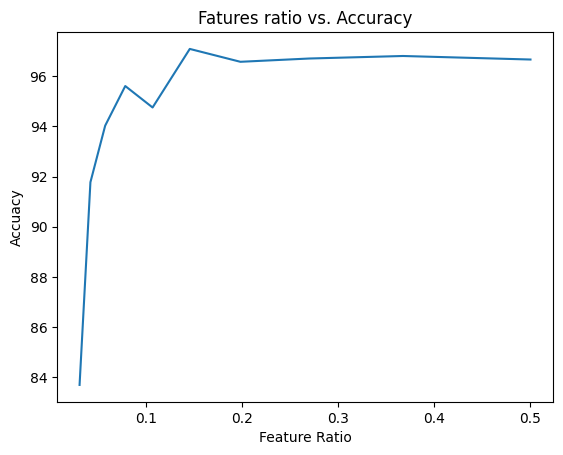

The accuracy improvement seems to drop off somewhere around the 0.14 features_ratio


In [38]:
# Just an example, change accordingly
features_ratios = np.logspace(1, 5, 10, base = .5)

#Workspace 4.9
#BEGIN
print(features_ratios[::-1])

accuracies_list = []
for ratio in features_ratios:
    classifier = RandomForest(N = 5, samples_ratio = 0.73, features_ratio = ratio, base=DecisionTreeClassifier(max_depth=5))
    classifier.fit(data.X_train, data.y_train)
    accuracy = k_fold_cv(classifier, 4, data.X_train, data.y_train)
    accuracies_list.append(accuracy*100)
    
plt.plot(features_ratios, accuracies_list)
plt.title("Fatures ratio vs. Accuracy")
plt.xlabel("Feature Ratio")
plt.ylabel("Accuacy")
plt.show()

print("The accuracy improvement seems to drop off somewhere around the 0.14 features_ratio")
#END

**Boosting**

There are different methods of boosting, but we'll focus in this problem on Adaptive Boosting (AdaBoost).
The logic of AdaBoost is to "push" each new learner to give more importance to previously misclassified data. We present
below the multiclass variant of AdaBoost [SAMME](https://web.stanford.edu/~hastie/Papers/samme.pdf). We denote $K$ the number of classes.

AdaBosst is performed by increasing the weights of misclassified simple after each iteration:
- Input: m samples $(X_i, y_i)_{i\in [m]}$, number of boosting rounds $N$
- Start with equal samples weights $W = (w_i), $ where   $w_i = \frac{1}{\texttt{n_samples}}$
- at round j:
    - Train estimator $h_j$ using current weights $W$
    - Get the predicted $(\hat{y}_i)$ on the training data using $h_j$
    - Find the weighted error rate $\epsilon_j$ using $W$: $\epsilon_j=\frac{\sum_i w_i \Delta(\hat{y}_i, y_i)}{\sum_i w_i}$
    - Choose $\alpha_j = \log \frac{1-\epsilon_j}{\epsilon_j} + \log(K-1)$
    - Update $W$ using: $w_i \leftarrow w_i \exp(\alpha_j \Delta(\hat{y_i}, y_i)) $
    - Normalize $W$ to have sum 1
- Global estimator is $H = \sum_j \alpha_j h_j$,

the $\Delta$ function equals to 1 when the two argument are different, 0 otherwise.

To understand how we implement $H$, imagine we have two classes, and we boosted for 3 rounds to get $(h_1, h_2, h_3)$,
with weights $(\alpha_1, \alpha_2, \alpha_3)$. When we want to predict the label of sample $x$, we get $(h_1(x), h_2(x), h_3(x)) = (0,1,0)$.

In this case, label $0$ gets a weight $\alpha_1+\alpha_3$, while class $1$ get weight $\alpha_2$. The predicted class is the one with
the largest weight (1 if $\alpha_2 > \alpha_1 + \alpha_3$, 0 otherwise)

### Problems 4.10- 4.11 Implementing Boosting - 6 points

- 4.10 [4 pts] Complete `fit` by building `n_estimators` of DecisionTreeClassifier, each trained on the same data but with different samples weights as detailed in the algorithm. Keep track of $(\alpha_i)$

_Hint: our weak learner (DecisionTreeClassifier) can take an argument `sample_weight` when calling the `fit` method, you'll have to use it to provide the weights $W$_

- 4.11  [2 pts] Complete `predict` method to return the predicted label using the global estimator $H$. 

_Hint: use one hot encoding of the predicted labels from the weak learners and cumulate the prediction with weights $\alpha_j$, a dictionary will also work_

Notice that if the estimator is consistent (0 error rate on the training set), AdaBoost $\alpha_j$ are no longer defined. That's why this method requires a **weak** learner like the base model we used in the previous problems.

In [39]:
class AdaBoost(object):

    def __init__(self, n_estimators, base = DecisionTreeClassifier(max_depth=4)):
        """
        :param n_estimators: number of estimators/ boosting rounds
        """
        self.n_estimators = n_estimators
        self.num_classes = None
        self.estimators = []
        self.alphas = np.zeros(n_estimators)
        self.base = base

    def fit(self, X_train, y_train):

        self.num_classes = np.unique(y_train).shape[0] # K in the algorithm
        weights = np.ones(len(X_train)) / len(X_train) # W in the algorithm
        # Workspace 4.10
        #TODO: Implement Multiclass Adaboost and keep track of the alpha_j
        #BEGIN
        
        for i in range(self.n_estimators):
            classifier = clone(self.base)
            classifier.fit(X_train, y_train, sample_weight= weights)
            
            y_hat = classifier.predict(X_train)
            incorrect_bool_vec = (y_hat != y_train)
            error_rate = np.sum(weights[incorrect_bool_vec])/np.sum(weights)
            alpha = np.log((1-error_rate) / error_rate) + np.log(self.num_classes - 1)
            
            weights *= np.exp(alpha * incorrect_bool_vec)
            weights /= np.sum(weights)
            
            self.estimators.append(classifier)
            self.alphas[i] = alpha

        # print(f"alphas {self.alphas}")
        #END

    def predict(self, X_test):
        # Workspace 4.11
        #TODO: get the labels returned by the global estimator defined as H
        #Hint: Use one-hot format to accumulate alphas for different classes, or a dictionary
        # The predicted label is the one that accumulates the largest sum of alphas
        #Hint: We don't need predict_proba for this one
        #BEGIN
        # y_hat is one-hot encoding of the multi-class labels
        # np.eye(k)[i] returns the one-hot encoding of size k for label i
        # np.eye(4)[2] would be [0, 0, 1, 0], np.eye(4)[0] is [1,0, 0, 0]. Clever, innit?
        
        prediction_array = np.zeros((self.n_estimators, len(X_test)))
        
        for i in range(self.n_estimators):
            prediction_array[i] = self.estimators[i].predict(X_test)

        prediction_array = prediction_array.T 
        
        alphas = self.alphas
        
        def voting(y):
            nonlocal alphas
            num_votes = {}
            for j in range(len(y)):
                num_votes[y[j]] = num_votes.get(y[j], 0) + alphas[j]
            
            max_vote = 0
            label = None
            for vote in num_votes:
                if num_votes[vote] > max_vote:
                    label = vote
                    max_vote = num_votes[vote]
            return label
        answer = np.array([voting(y) for y in prediction_array])
        #END
        return answer

In [40]:
classifier = AdaBoost(3)
classifier.fit(data.X_train, data.y_train)
classifier.predict(data.X_valid)

array([-1.,  1., -1., ...,  1., -1.,  1.])

In [41]:

depths = np.arange(1,10)
Ns = np.linspace(1,45,10, dtype=int)


print(f"Examined depths:\n\t{depths}")
print(f"Examined N values:\n\t{Ns}")
# Workspace 4.5
# BEGIN
init_values = [(N, depth) for depth in depths for N in Ns]


def ada_score(n_est=1, depth=4):
    classifier = AdaBoost(n_estimators=n_est,
                          base=DecisionTreeClassifier(max_depth=depth))
    classifier.fit(data.X_train, data.y_train)
    y_hat = classifier.predict(data.X_valid)
    return np.sum((data.y_valid == y_hat))/len(y_hat), n_est, depth

pool = Pool(24)
outputs = []
for result in pool.starmap(ada_score, init_values):
    outputs.append(result)

outputs = np.array(outputs)




Examined depths:
	[1 2 3 4 5 6 7 8 9]
Examined N values:
	[ 1  5 10 15 20 25 30 35 40 45]


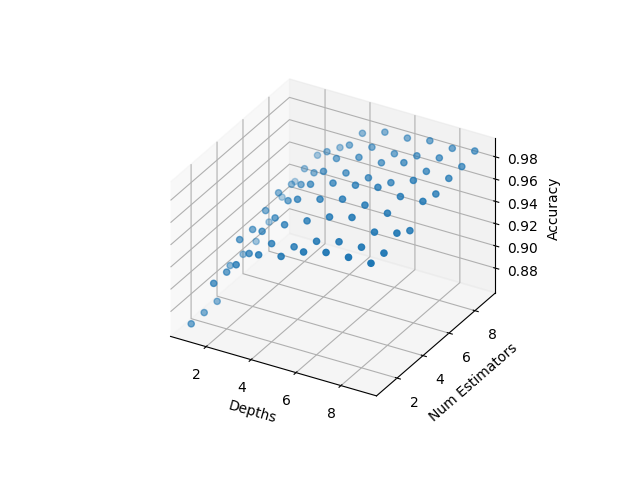

In [45]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.set_proj_type('ortho')
ax.scatter(outputs[:, 2], outputs[:, 1], outputs[:, 0])

ax.set_xlabel('Depths')
ax.set_ylabel('Num Estimators')
ax.set_zlabel('Accuracy')

plt.show()


### Problem 4.12 Hyperparameter tuning on Adaboost [4 points]
4.12 a [2 points] Try out different values for `max_depth` in base model and `n_estimators` to arrive at the best evaluation metrics on `ThreesAndEights` validation set after training on `ThreesAndEights` training set.

In [44]:
# Workspace 4.12a
#BEGIN
# TODO: Report accuracy and other appropriate metrics
# Make sure that the label values are >=0 if using np.eye for one-hot encoding

depths = np.arange(1, 10)
Ns = np.arange(1, 10, dtype=int)


print(f"Examined depths:\n\t{depths}")
print(f"Examined N values:\n\t{Ns}")
# Workspace 4.5
# BEGIN
init_values = [(N, depth) for depth in depths for N in Ns]


def ada_score(n_est=1, depth=4):
    classifier = AdaBoost(n_estimators=n_est,
                          base=DecisionTreeClassifier(max_depth=depth))
    classifier.fit(data.X_train, data.y_train)
    y_hat = classifier.predict(data.X_valid)
    return np.sum((data.y_valid == y_hat))/len(y_hat), n_est, depth


pool = Pool(24)
outputs = []
for result in pool.starmap(ada_score, init_values):
    outputs.append(result)

outputs = np.array(outputs)
#END

Examined depths:
	[1 2 3 4 5 6 7 8 9]
Examined N values:
	[1 2 3 4 5 6 7 8 9]


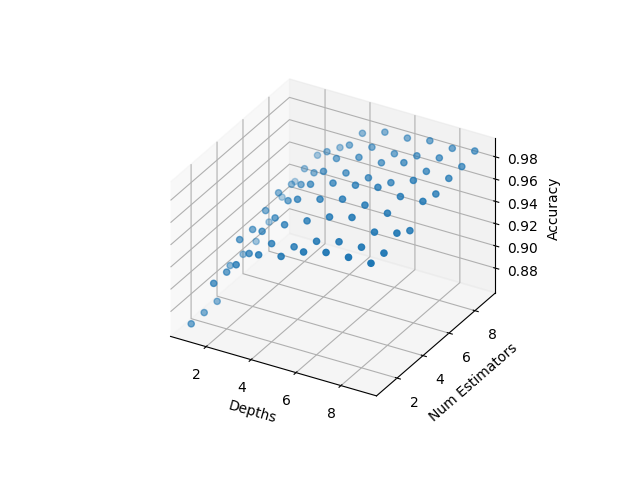

In [46]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')


ax.set_proj_type('ortho')
ax.scatter(outputs[:, 2], outputs[:, 1], outputs[:, 0])

ax.set_xlabel('Depths')
ax.set_ylabel('Num Estimators')
ax.set_zlabel('Accuracy')

plt.show()


<head>
It appears that

depth = 5
Number Estimators = 3

Is optimal for the SAMME method that we are using.
<head>

4.12 b [1 point] What are your observations with respect to `max_depth` in the base model? 

% Write-up for 4.12.b <br>
#BEGIN <br>
The accuracy seems to be roughly logarithmic in the depth of the decision tree. However, above a depth of 5 or so the 
accuracy improvements are marginal.

#END<br>

4.12 c [1 point] What are your observations with respect to `n_estimators`?

% Write-up for 4.12.c <br>
#BEGIN <br>
The number of estimators seems to have a very sharp performance improvement dropoff past around 3 or 4.

#END<br>